Kütüphaneleri Ekleme

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import seaborn as sns
from scipy.stats import zscore
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split # Eğitim ve test verileri bölünmemiş durumdadır.
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Veri Yükleme

In [3]:
# import glob
# from PIL import Image, ImageOps
# df2_filelist_normal=glob.glob('TB_Chest_Radiography_Database/Normal/*.png')
# df2_filelist_tuberc=glob.glob('TB_Chest_Radiography_Database/Tuberculosis/*.png')
# df2_x_normal=np.array([np.array(ImageOps.grayscale(Image.open(fname)).resize((64,64), Image.ANTIALIAS)) for fname in df2_filelist_normal])
# df2_x_tuberc=np.array([np.array(ImageOps.grayscale(Image.open(fname)).resize((64,64), Image.ANTIALIAS)) for fname in df2_filelist_tuberc])
# np.save('TB_Chest_Radiography_Database_Normal',np.array(df2_x_normal))
# np.save('TB_Chest_Radiography_Database_Tuberculosis',np.array(df2_x_tuberc))

In [4]:
df2_x_normal=np.load('TB_Chest_Radiography_Database_Normal.npy')
df2_x_tuberc=np.load('TB_Chest_Radiography_Database_Tuberculosis.npy')

In [5]:
print(df2_x_normal.shape)
print(df2_x_tuberc.shape)

(3500, 64, 64)
(700, 64, 64)


In [6]:
#Creating labels.
df2_y_normal=[]
df2_y_tuberc=[]
for i in range(len(df2_x_normal)):
    df2_y_normal.append(0)
for i in range(len(df2_x_tuberc)):
    df2_y_tuberc.append(1)
df2_y_normal=np.array(df2_y_normal)
df2_y_tuberc=np.array(df2_y_tuberc)

In [7]:
print(df2_y_normal.shape)
print(df2_y_tuberc.shape)

(3500,)
(700,)


In [8]:
df2_X=np.concatenate((df2_x_normal[0:1749,:,:],df2_x_tuberc[0:349,:,:]))
print(df2_X.shape)

(2098, 64, 64)


In [9]:
# Matristen vektöre dönüştürme
df2_nsamples,df2_nx,df2_ny=df2_X.shape
df2_x=df2_X.reshape((df2_nsamples,df2_nx*df2_ny))
print(df2_x.shape)

(2098, 4096)


In [10]:
df2_Y=np.concatenate((df2_y_normal[0:1749],df2_y_tuberc[0:349]))
print(df2_Y.shape)

(2098,)


In [11]:
df2_y=df2_Y
#df2_y=df2_Y.reshape(-1, 1)
#print(df2_y.shape)

# YSA Uygulaması

In [39]:
df2_x_ysa_trn,df2_x_ysa_tst,df2_y_ysa_trn,df2_y_ysa_tst=train_test_split(df2_x,df2_y,test_size=0.2,random_state=1) # test_size ile yüzdelik bölünme belirlendi,her seferde aynı seçim yapması için random_state belirlendi.

In [40]:
print("Veriseti 2 - Eğitim Verisi")
print(df2_x_ysa_trn.shape)
print(df2_y_ysa_trn.shape)
print("Veriseti 2 - Test Verisi")
print(df2_x_ysa_tst.shape)
print(df2_y_ysa_tst.shape)

Veriseti 2 - Eğitim Verisi
(1678, 4096)
(1678,)
Veriseti 2 - Test Verisi
(420, 4096)
(420,)


In [41]:
# Çıktı verilerini vektörden matrise dönüştürme
df2_y_ysa_tst=df2_y_ysa_tst.reshape(-1,1)
df2_y_ysa_trn=df2_y_ysa_trn.reshape(-1,1)

In [42]:
# Veri bilgilerini öğrenme
print("df2 x ysa train:",df2_x_ysa_trn.shape)
print("df2 y ysa train:",df2_y_ysa_trn.shape)
print("df2 x ysa test:",df2_x_ysa_tst.shape)
print("df2 y ysa test:",df2_y_ysa_tst.shape)

df2 x ysa train: (1678, 4096)
df2 y ysa train: (1678, 1)
df2 x ysa test: (420, 4096)
df2 y ysa test: (420, 1)


In [43]:
# İlk ağırlıkları ve biası tanımlayan fonksiyon
def initialize_weights_and_bias(dimension):
    w = np.full((dimension,1),0.01) # girilen boyuta göre 0.01 verisinden oluşan ağırlık matrisi oluşturur
    b = 0.0 # float olarak sıfır değerinde bias oluşturur
    return w,b

In [44]:
# Transfer fonksiyonunun oluşturulması (ara çıktı)
def transfer(x,w,b):
    z=np.dot(x,w)+b # Toplama fonksiyonu
    return z

In [45]:
# Aktivasyon fonksiyonunun oluşturulması (ön çıktı)
def activation(z):
    y_head=1/(1+np.exp(-z)) # Sigmoid/Logistic fonksiyonu
    return y_head

In [46]:
# İleri ve geri yayılım fonksiyonunun oluşturulması
def forward_backward_propagation(w,b,x_train,y_train):
    # İleri yayılım (Maliyet fonksiyonu)
    z=transfer(x_train,w,b) # Ara çıktı olarak (455,1) matris elde edilecek
    y_head=activation(z) # Her z için ön çıktı hesaplama
    loss=-y_train*np.log(y_head)-(1-y_train)*np.log(1-y_head) # Kayıp/Hata
    cost=(np.sum(loss))/x_train.shape[0] # Maliyet
    
    # Geri yayılım (Türev ile eğimler bulunur)
    # Türevi alınan ağırlıklar ve bias hesaplanır.
    derivative_weight=(np.dot(x_train.T,((y_head-y_train))))/x_train.shape[0] 
    derivative_bias=np.sum(y_head-y_train)/x_train.shape[0]                 
    # Döndürmek için bir sözlüğe eklenir 
    gradients={"derivative_weight":derivative_weight,"derivative_bias":derivative_bias}
    
    return cost,gradients

In [47]:
# Geri yayılım doğrultusunda ağırlıkların ve biasın güncellenmesi
def update(w,b,x_train,y_train,learning_rate,number_of_iterarion):
    # Her 1 adımda ve her 10 adımda depolaması için bir list oluşturma
    cost_list01=[]
    cost_list10=[]
    # İterasyon sayısını tutmak içinde bir liste oluşturma
    index=[]
    
    # Gadyan azalmalı optimizasyon algoritması
    for i in range(number_of_iterarion):
        cost,gradients=forward_backward_propagation(w,b,x_train,y_train) # Türevleri aldırma
        w=w-learning_rate*gradients["derivative_weight"] # Yeni ağırlıkları hesaplatma
        b=b-learning_rate*gradients["derivative_bias"] # Yeni biası hesaplatma
        cost_list01.append(cost) # Her 1 adımda maliyet çıktısının depolanması
        if i%10==0:
            index.append(i)
            cost_list10.append(cost) # Her 10 adımda maliyet çıktısının depolanması
            print("Cost after iteration %i: %f" %(i,cost))
            
    # Ağırlıkları ve biası güncelle
    parameters={"weight":w,"bias":b}
    
    # Her 10 adımda maliyet çıktısının grafikle gösterilmesi
    plt.plot(index,cost_list10)
    plt.xticks(index,rotation='vertical')
    plt.xlabel("Number of Iterarion")
    plt.ylabel("Cost")
    plt.show()
    
    return parameters,gradients,cost_list01

In [48]:
# Sonuç çıktısını oluşturmak için tahmin fonksiyonu
def predict(w,b,x_test):
    z=transfer(x_test,w,b)
    y_head=activation(z) # Ön çıktı hesaplama
    
    y_prediction=np.zeros((x_test.shape[0],1)) # Ön çıktıdan tahminde bulunma
    
    for i in range(y_head.shape[0]):
        if y_head[i,0]<=0.5:
            y_prediction[i,0]=0
        else:
            y_prediction[i,0]=1

    return y_prediction

In [49]:
# Tüm fonksiyonların birleştirildiği ana fonksiyonun oluşturulması
def logistic_regression(x_train,y_train,x_test,y_test,learning_rate,num_iterations):
    # Initialize (İlk Yükleme)
    dimension=x_train.shape[1] 
    w,b=initialize_weights_and_bias(dimension)
    
    # Değerlendirme yapılarak yeni parametrelerin belirlenmesi
    parameters,gradients,cost_list=update(w,b,x_train,y_train,learning_rate,num_iterations)
    
    # Yeni parametreler kullanılarak test verisinde tahminin yapılması
    y_prediction_test=predict(parameters["weight"],parameters["bias"],x_test)

    # Accuracy (Doğruluk) [doğru tahminler/test sayısı]
    print("Test Accuracy: {} %".format(100-np.mean(np.abs(y_prediction_test-y_test))*100))
    
    return y_prediction_test,y_test

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in multiply
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


Cost after iteration 0: nan
Cost after iteration 10: nan
Cost after iteration 20: nan
Cost after iteration 30: nan
Cost after iteration 40: nan
Cost after iteration 50: nan
Cost after iteration 60: nan
Cost after iteration 70: nan
Cost after iteration 80: nan
Cost after iteration 90: nan
Cost after iteration 100: nan
Cost after iteration 110: nan
Cost after iteration 120: nan
Cost after iteration 130: nan
Cost after iteration 140: nan
Cost after iteration 150: nan
Cost after iteration 160: nan
Cost after iteration 170: nan
Cost after iteration 180: nan
Cost after iteration 190: nan


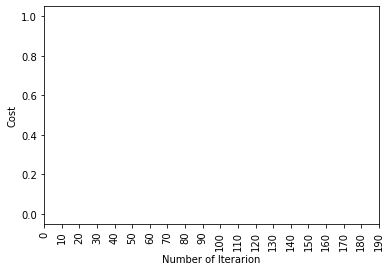

Test Accuracy: 82.61904761904762 %


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


In [52]:
df2_y_ysa_pred,df2_y_ysa_true=logistic_regression(df2_x_ysa_trn,df2_y_ysa_trn,df2_x_ysa_tst,df2_y_ysa_tst,learning_rate=1,num_iterations=200)  

In [51]:
# Sklearn ile lineer regresyon yapılsaydı
df2_linreg=LogisticRegression(solver="newton-cg")
df2_linreg.fit(df2_x_ysa_trn,df2_y_ysa_trn.ravel()) # Matris olarak ayarlanan y çıktısı tekrardan vektöre geri döndürüldü
print("Skor:",df2_linreg.score(df2_x_ysa_tst,df2_y_ysa_tst))

Skor: 0.9404761904761905


# MLP Uygulaması

In [54]:
# Eğitim ve test verisini ayırma
df2_x_mlp_trn,df2_x_mlp_tst,df2_y_mlp_trn,df2_y_mlp_tst=train_test_split(df2_x,df2_y,test_size=20,random_state=1)

In [55]:
print(MLPClassifier())

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


In [56]:
df2_mlpc_model1=MLPClassifier(max_iter=200)
df2_mlpc_model1.fit(df2_x_mlp_trn,df2_y_mlp_trn)
print("Skor:",df2_mlpc_model1.score(df2_x_mlp_tst,df2_y_mlp_tst))

Skor: 0.95


In [57]:
df2_mlpc_model2=MLPClassifier(solver="lbfgs",activation="logistic",max_iter=200,hidden_layer_sizes=(3,5),random_state=1)
df2_mlpc_model2.fit(df2_x_mlp_trn,df2_y_mlp_trn)
print("Skor:",df2_mlpc_model2.score(df2_x_mlp_tst,df2_y_mlp_tst))

Skor: 0.6


# K-fold Cross Validation (Verileri Ayırarak Deneme)

In [58]:
df2_knn_k=KNeighborsClassifier(n_neighbors=3)
df2_scores_k=cross_val_score(estimator=df2_knn_k,X=df2_x,y=df2_y,cv=5) # Tek sayılar ve az veride düşük değerler terch edilmelidir.

for score in df2_scores_k:
    print(score)

print("Ortalama Skor:",np.mean(df2_scores_k))

0.9666666666666667
0.9404761904761905
0.9285714285714286
0.9379474940334129
0.9045346062052506
Ortalama Skor: 0.9356392771905897


## Dahili K-fold

In [61]:
df2_scores=[]
df2_kf=KFold(n_splits=5)
df2_mlpc_modelK=MLPClassifier(solver="lbfgs",activation="relu",max_iter=200,hidden_layer_sizes=(3,5))

for train_indexler,test_indexler in df2_kf.split(df2_x):
    df2_mlpc_modelK.fit(df2_x[train_indexler],df2_y[train_indexler])
    df2_score=df2_mlpc_modelK.score(df2_x[test_indexler],df2_y[test_indexler])
    df2_scores.append(df2_score)
    print(df2_score)
    
print("Ortalama Skor:",np.mean(df2_scores))

0.9404761904761905
1.0
0.0
0.0
0.16706443914081145
Ortalama score: 0.42150812592340037


# Grid Search (Uygun Hiperparametreleri Belirleme)

In [12]:
df2_x_grd_trn,df2_x_grd_tst,df2_y_grd_trn,df2_y_grd_tst=train_test_split(df2_x,df2_y,test_size=0.2,random_state=1)

In [15]:
df2_mlpc_modelGrid=MLPClassifier(activation="logistic",random_state=1)
df2_mlpc_modelGrid_params={"alpha":[0.1,0.01,0.001],
            "hidden_layer_sizes":[(5,5),(3,3,3),(7,7)],
            "solver":["lbfgs","adam","sgd"]}

In [16]:
df2_mlpc_modelGridSearchCV=GridSearchCV(df2_mlpc_modelGrid,df2_mlpc_modelGrid_params,cv=5,n_jobs=-1,verbose=2).fit(df2_x_grd_trn,df2_y_grd_trn)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:  7.1min finished


In [17]:
print(df2_mlpc_modelGridSearchCV.best_params_)

{'alpha': 0.01, 'hidden_layer_sizes': (7, 7), 'solver': 'lbfgs'}


In [18]:
df2_mlpc_modelTuned=MLPClassifier(alpha=0.01,hidden_layer_sizes=(7,7),solver="lbfgs").fit(df2_x_grd_trn,df2_y_grd_trn)
print("Score:",df2_mlpc_modelTuned.score(df2_x_grd_tst,df2_y_grd_tst))

Score: 0.1738095238095238


# Model Değerlendirme

In [19]:
df2_x_eva_trn,df2_x_eva_tst,df2_y_eva_trn,df2_y_eva_tst=train_test_split(df2_x,df2_y,test_size=0.2,random_state=1)

In [20]:
df2_mlpc_modelEva=MLPClassifier(alpha=0.01,hidden_layer_sizes=(3,5),solver="lbfgs",activation="logistic",max_iter=500).fit(df2_x_eva_trn,df2_y_eva_trn)
df2_y_eva_pred=df2_mlpc_modelEva.predict(df2_x_eva_tst)

In [21]:
acc=metrics.accuracy_score(df2_y_eva_tst,df2_y_eva_pred)
cm=metrics.confusion_matrix(df2_y_eva_tst,df2_y_eva_pred)
f1=metrics.f1_score(df2_y_eva_tst,df2_y_eva_pred)
cr=metrics.classification_report(df2_y_eva_tst,df2_y_eva_pred)
print("Accuracy Score:",acc)
print("F1 Score:",f1)
print("Confusion Matrix:")
print("DD-YD")
print("YY-DY")
print(cm)
print("Classification Report:")
print(cr)

Accuracy Score: 0.8261904761904761
F1 Score: 0.0
Confusion Matrix:
DD-YD
YY-DY
[[347   0]
 [ 73   0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      1.00      0.90       347
           1       0.00      0.00      0.00        73

    accuracy                           0.83       420
   macro avg       0.41      0.50      0.45       420
weighted avg       0.68      0.83      0.75       420



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


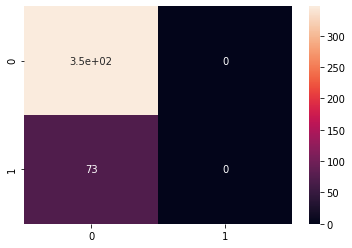

In [22]:
# Confusion Matrix Görselleştirme
sns.heatmap(cm,annot=True)

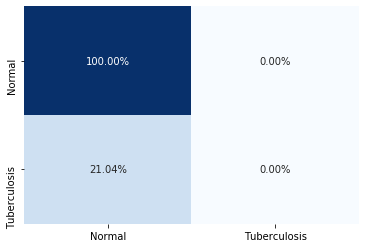

In [23]:
class_adlari=["Normal","Tuberculosis"] # 0:normal 1:diabet
sns.heatmap(cm/cm.sum(axis=1),annot=True,cbar=False,cmap="Blues",xticklabels=class_adlari,yticklabels=class_adlari,fmt=".2%")

In [24]:
# ROC ve AUC
df2_probs_eva=df2_mlpc_modelEva.predict_proba(df2_x_eva_tst) # Her aktivasyon eşiği için sonucun doğru olma ihtimalleri
print(df2_probs_eva) # Solda 0 olma ihtimali, sağda 1 olma ihtimali
df2_probs_eva=df2_probs_eva[:,1] # Sadece 1 olma ihtimallerinin çekilmesi
print(df2_probs_eva)
# FPR: False Positive Rate (x ekseni)
# TPR: True Positive Rate (y ekseni)
fpr,tpr,threshold=metrics.roc_curve(df2_y_eva_tst,df2_probs_eva)
auc_value=metrics.auc(fpr,tpr)

[[0.8355242 0.1644758]
 [0.8355242 0.1644758]
 [0.8355242 0.1644758]
 [0.8355242 0.1644758]
 [0.8355242 0.1644758]
 [0.8355242 0.1644758]
 [0.8355242 0.1644758]
 [0.8355242 0.1644758]
 [0.8355242 0.1644758]
 [0.8355242 0.1644758]
 [0.8355242 0.1644758]
 [0.8355242 0.1644758]
 [0.8355242 0.1644758]
 [0.8355242 0.1644758]
 [0.8355242 0.1644758]
 [0.8355242 0.1644758]
 [0.8355242 0.1644758]
 [0.8355242 0.1644758]
 [0.8355242 0.1644758]
 [0.8355242 0.1644758]
 [0.8355242 0.1644758]
 [0.8355242 0.1644758]
 [0.8355242 0.1644758]
 [0.8355242 0.1644758]
 [0.8355242 0.1644758]
 [0.8355242 0.1644758]
 [0.8355242 0.1644758]
 [0.8355242 0.1644758]
 [0.8355242 0.1644758]
 [0.8355242 0.1644758]
 [0.8355242 0.1644758]
 [0.8355242 0.1644758]
 [0.8355242 0.1644758]
 [0.8355242 0.1644758]
 [0.8355242 0.1644758]
 [0.8355242 0.1644758]
 [0.8355242 0.1644758]
 [0.8355242 0.1644758]
 [0.8355242 0.1644758]
 [0.8355242 0.1644758]
 [0.8355242 0.1644758]
 [0.8355242 0.1644758]
 [0.8355242 0.1644758]
 [0.8355242

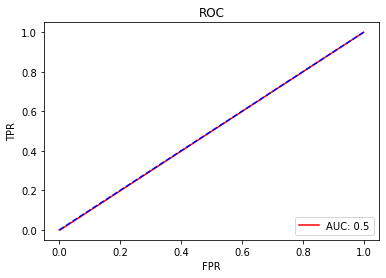

In [25]:
plt.plot(fpr,tpr,color="red",label="AUC: "+str(round(auc_value,2)))
plt.title("ROC")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(loc="lower right")
plt.plot([0,1],[0,1],color="blue",linestyle="--")
plt.show()

In [26]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [27]:
import keras
print(keras.__version__)

2.5.0
